In [2]:
%pip install sentence-transformers umap-learn matplotlib
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 488 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 25.3 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 17.1 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 8.1 MB/s eta 0:00:01
     |████████████████████████████████| 12.0 MB 95.4 MB/s eta 0:00:01
     |████████████████████████████████| 515 kB 102.0 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 34.3 MB/s eta 0:00:01
     |████████████████████████████████| 30.3 MB 80.1 MB/s eta 0:00:01
     |████████████████████████████████| 73.6 MB 23.4 MB/s eta 0:00:01
     |████████████████████████████████| 11.1 MB 22.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.3 MB 22.4 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 35.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.7 MB 23.7 MB/s eta 0:00:01
     |███████████████████

/Users/studiocat/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/studiocat/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib is building the font cache; this may take a moment.


In [10]:
# SAMPLE DATA

data = {
    "apple": "fruit",
    "banana": "fruit",
    "orange": "fruit",
    "cat": "animal",
    "dog": "animal",
    "hamster": "animal",
    "Harvard University": "school",
    "MIT": "school",
    "Stanford University": "school"
}


data = {
    "man": "man",
    "woman": "woman",
    "girl": "girl",
    "king": "king",
    "queen": "queen",
}

texts = list(data.keys())
labels = list(data.values())

/Users/studiocat/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/studiocat/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


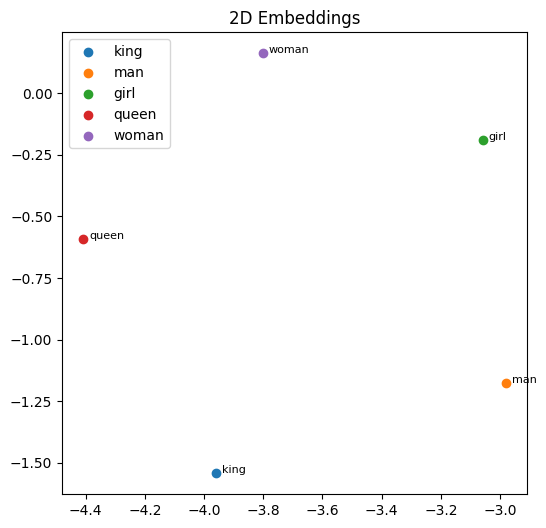

In [11]:
# EMBED TEXTS AND REDUCE DIMENSIONS
model = SentenceTransformer("all-MiniLM-L6-v2")
emb = model.encode(texts)
reducer = umap.UMAP(n_components=2, random_state=42)
emb2d = reducer.fit_transform(emb)

# PLOTTING

plt.figure(figsize=(6, 6))
unique_labels = set(labels)

for label in unique_labels:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(emb2d[idx, 0], emb2d[idx, 1], label=label)

for i, txt in enumerate(texts):
    plt.text(emb2d[i, 0] + 0.02, emb2d[i, 1], txt, fontsize=8)

plt.legend()
plt.title("2D Embeddings")
plt.show()

In [ ]:
%pip install transformers matplotlib torch --quiet

import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


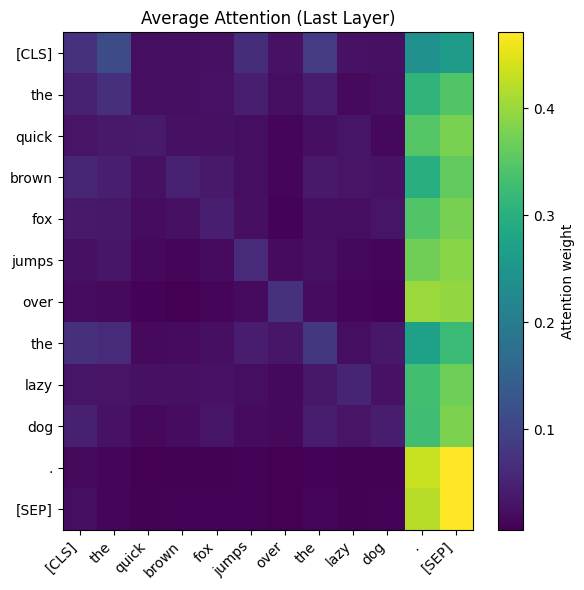

In [21]:
text = "The quick brown fox jumps over the lazy dog."

tokens = tokenizer(text, return_tensors="pt")
outputs = model(**tokens)

# attention: list of (batch, heads, seq, seq)
att = outputs.attentions[-1][0]   # last layer, batch 0
att = att.mean(dim=0).detach()    # average over heads → (seq, seq)

# --- Token labels ---
token_labels = tokenizer.convert_ids_to_tokens(tokens["input_ids"][0])

# --- Plot ---
plt.figure(figsize=(6, 6))
plt.imshow(att, cmap="viridis", aspect="auto")
plt.xticks(range(len(token_labels)), token_labels, rotation=45, ha="right")
plt.yticks(range(len(token_labels)), token_labels)
plt.colorbar(label="Attention weight")
plt.title("Average Attention (Last Layer)")
plt.tight_layout()
plt.show()


In [ ]:
# Minimal attention-demo notebook cell

# !pip install transformers torch matplotlib

import torch
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from transformers import AutoTokenizer, AutoModel

# 1. Load model + tokenizer (real transformer, output_attentions=True)
name = "distilbert-base-uncased"
tok = AutoTokenizer.from_pretrained(name)
model = AutoModel.from_pretrained(name, output_attentions=True)

# 2. Pick a sentence (change as you like)
sentence = "The person in a blue shirt went to the store today"
enc = tok(sentence, return_tensors="pt")

with torch.no_grad():
    out = model(**enc)

# 3. Get attention: last layer, head 0 -> shape [seq, seq]
att = out.attentions[-4][0, 0].numpy()   # [seq_q, seq_k]
tokens = tok.convert_ids_to_tokens(enc["input_ids"][0])
L = len(tokens)

# 4. Animated heatmap: each frame = attention from one query token
fig, ax = plt.subplots(figsize=(6, 3))
im = ax.imshow(att[0][None, :], vmin=0, vmax=att.max(), aspect="auto")
ax.set_xticks(range(L))
ax.set_xticklabels(tokens, rotation=90, fontsize=8)
ax.set_yticks([])
title = ax.set_title(f"Query: {tokens[0]}")

def update(i):
    im.set_data(att[i][None, :])      # row i = attention from token i to all tokens
    title.set_text(f"Query: {tokens[i]}")
    return im, title

ani = animation.FuncAnimation(fig, update, frames=L, interval=600, blit=True)
plt.tight_layout()
HTML(ani.to_jshtml())
